### 載入使用到的套件

In [1]:
library(ggplot2)
library(randomForest)
library(rpart)
library(e1071)
library(DMwR)
library(ROCR)
library(fastAdaboost)

options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice

Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### 載入測試資料集

In [2]:
df.train <- read.csv('./hw2/training.csv', sep = ',')
df.test <- read.csv('./hw2/testing.csv', sep = ',')

### 檢視資料集

#### 檢視欄位

In [3]:
colnames(df.train)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

#### 檢視分類標籤欄位資料量比例

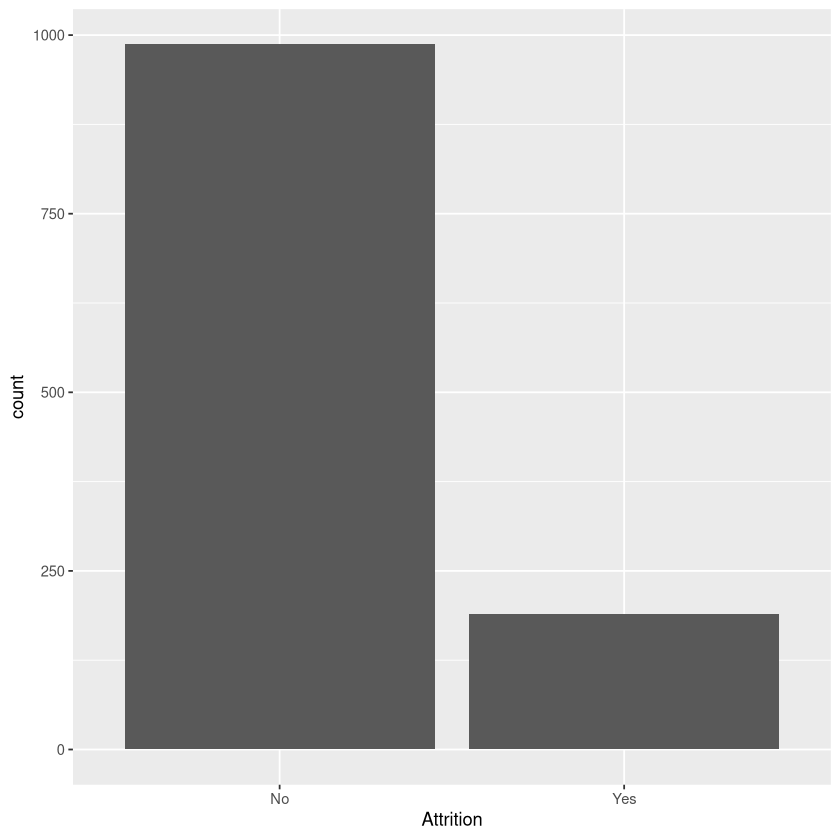

In [4]:
ggplot(df.train, aes(x = Attrition)) + geom_bar()

#### 檢視其他欄位與分類標籤欄位之比例

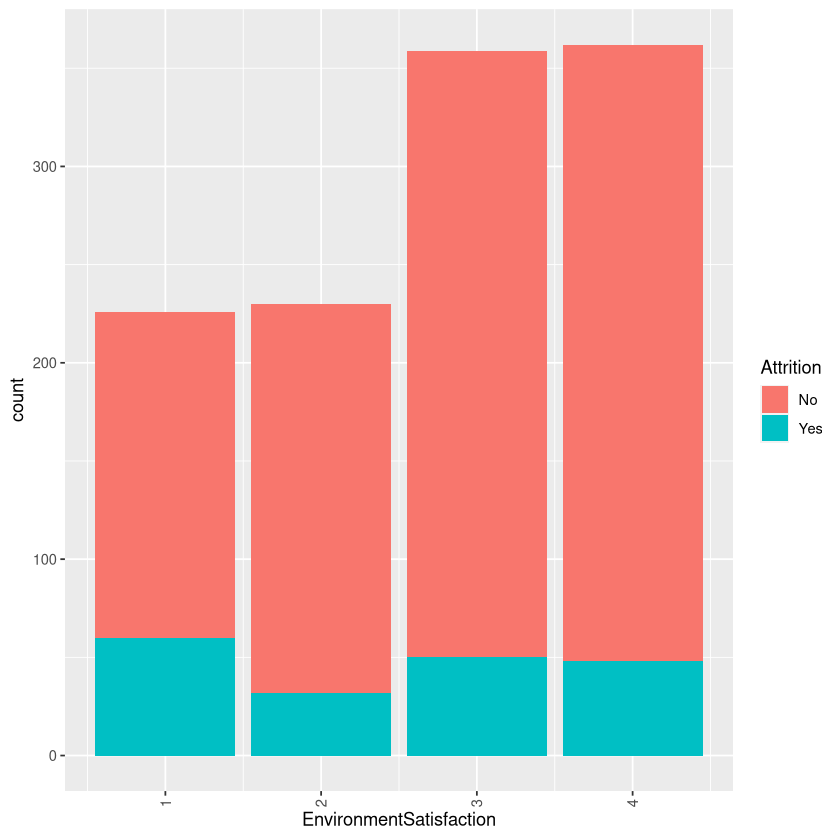

In [5]:
ggplot(df.train, aes(x = EnvironmentSatisfaction, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

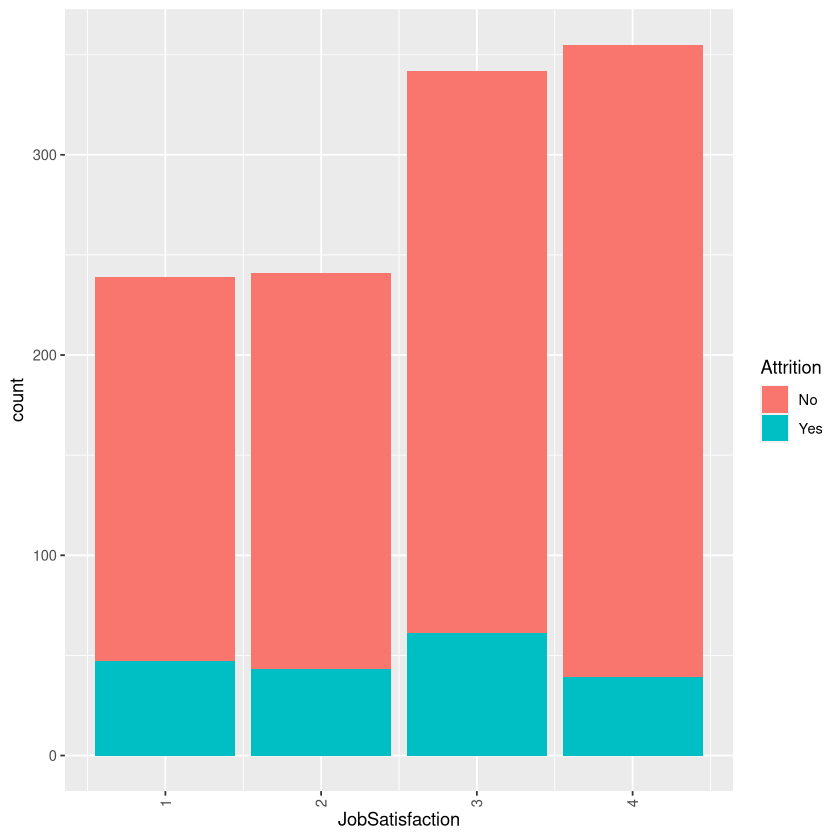

In [6]:
ggplot(df.train, aes(x = JobSatisfaction, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

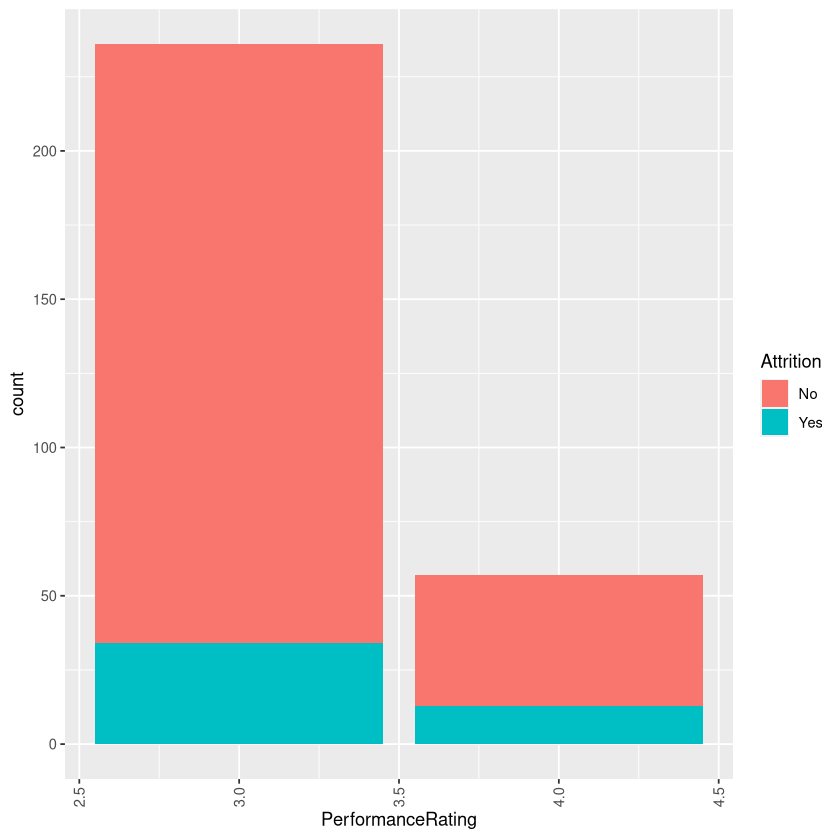

In [7]:
ggplot(df.test, aes(x = PerformanceRating, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

#### 檢視統計分佈

In [8]:
summary(df.train)

      Age         Attrition         BusinessTravel      Department       
 Min.   :18.00   Length:1177        Length:1177        Length:1177       
 1st Qu.:30.00   Class :character   Class :character   Class :character  
 Median :36.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :36.82                                                           
 3rd Qu.:42.00                                                           
 Max.   :60.00                                                           
 DistanceFromHome   Education     EducationField     EmployeeNumber
 Min.   : 1.000   Min.   :1.000   Length:1177        Min.   :   1  
 1st Qu.: 2.000   1st Qu.:2.000   Class :character   1st Qu.: 514  
 Median : 7.000   Median :3.000   Mode  :character   Median :1029  
 Mean   : 9.034   Mean   :2.926                      Mean   :1034  
 3rd Qu.:13.000   3rd Qu.:4.000                      3rd Qu.:1554  
 Max.   :29.000   Max.   :5.000                      Max.   :2065  
 Envir

#### 計算標籤比例

In [9]:
count_rate <- function(df, col_name, col_values){
  res <- list()
  for(col_value in col_values){
    res[col_value] <- (nrow(df.train[(df.train[col_name]==col_value) & (df.train['Attrition']=='Yes'), ]) / 
                      nrow(df.train[(df.train[col_name]==col_value), ]))
  }
  return(res)
}

In [10]:
# Gender
count_rate(df.train, 'Gender', c(as.character(unique(df.train[, 'Gender']))))

$Female
[1] 0.1561181

$Male
[1] 0.1650071

In [11]:
# BusinessTravel
count_rate(df.train, 'BusinessTravel', c(as.character(unique(df.train[, 'BusinessTravel']))))

$Travel_Rarely
[1] 0.1450654

$Travel_Frequently
[1] 0.2681818

$`Non-Travel`
[1] 0.07758621

In [12]:
# Department
count_rate(df.train, 'Department', c(as.character(unique(df.train[, 'Department']))))

$Sales
[1] 0.2087912

$`Research & Development`
[1] 0.1370224

$`Human Resources`
[1] 0.1851852

In [13]:
# JobRole
count_rate(df.train, 'JobRole', c(as.character(unique(df.train[, 'JobRole']))))

$`Sales Executive`
[1] 0.1703704

$`Research Scientist`
[1] 0.1561181

$`Laboratory Technician`
[1] 0.2227723

$`Healthcare Representative`
[1] 0.07920792

$Manager
[1] 0.0625

$`Manufacturing Director`
[1] 0.07758621

$`Sales Representative`
[1] 0.4242424

$`Research Director`
[1] 0.03278689

$`Human Resources`
[1] 0.2272727

In [14]:
# EducationField
count_rate(df.train, 'EducationField', c(as.character(unique(df.train[, 'EducationField']))))

$`Life Sciences`
[1] 0.1466395

$Other
[1] 0.1016949

$Medical
[1] 0.1428571

$Marketing
[1] 0.2132353

$`Technical Degree`
[1] 0.25

$`Human Resources`
[1] 0.2173913

In [15]:
# MaritalStatus
count_rate(df.train, 'MaritalStatus', c(as.character(unique(df.train[, 'MaritalStatus']))))

$Single
[1] 0.2473404

$Married
[1] 0.1365314

$Divorced
[1] 0.08880309

#### 根據上述結果設計數值轉換函式

In [16]:
gender_mapper <- function(gender){
  return(ifelse(gender == 'Male', 1, 0))
}
age_mapper <- function(age) {
  return(ifelse(age <= 30, 3,
         ifelse((30 < age && age <= 42), 2,
         ifelse(42 < age, 1, 0))))
}
travel_mapper <- function(travel) {
  return(ifelse(travel=='Travel_Rarely', 2,
         ifelse(travel=='Travel_Frequently', 3,
         ifelse(travel=='Non-Travel', 1, 0))))
}
department_mapper <- function(department){
  return(ifelse(department=='Research & Development', 3,
         ifelse(department=='Human Resources', 2,
         ifelse(department=='Sales', 1, 0))))
}
field_mapper <- function(field) {
  # 'Medical''Other''Marketing''Human Resources''Technical Degree'
  return(ifelse(field=='Other', 1,
         ifelse(field=='Life Sciences', 2,
         ifelse(field=='Medical', 3, 
         ifelse(field=='Marketing', 4,
         ifelse(field=='Human Resources', 5,
         ifelse(field=='Technical Degree', 6, 0)))))))
}
marital_mapper <- function(marital){
  return(ifelse(marital=='Single', 3,
         ifelse(marital=='Married', 2,
         ifelse(marital=='Divorced', 1, 0))))
}
role_mapper <- function(role){
  return(ifelse(role=='Sales Representative', 9,
         ifelse(role=='Human Resources', 8,
         ifelse(role=='Laboratory Technician', 8,
         ifelse(role=='Sales Executive', 6,
         ifelse(role=='Research Scientist', 5,
         ifelse(role=='Healthcare Representative', 4,
         ifelse(role=='Manufacturing Director', 3,
         ifelse(role=='Manager', 2,
         ifelse(role=='Research Director', 1,0))))))))))
}
attrition_mapper <- function(attrition){
  return(ifelse(attrition=='Yes', 1, 0))
}
couple_generator <- function(marital) {
  return(ifelse(marital=='Married', 1, 0))
}

#### 除了上述資料外，其他的資料處理函式

In [17]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    if(is.factor(df[, col])){
      df[, col] <- as.numeric(as.character(df[, col]))
    }else{
      df[, col] <- as.numeric(df[, col])      
    }
  } 
  return (df)
}
set_col_to_category <- function(df, old_col, new_col, mapper){
  df[new_col] <- as.factor(mapper(df[old_col]))
  return(df)
}
set_col_to_numerical_factor <- function(df, old_col, new_col) {
  df[, new_col] <- as.factor(as.numeric(as.factor(df[, old_col])))
  return(df)
}
set_col_to_log <- function(df, old_col, new_col){
  df[, new_col] <- df[, old_col]
  df[df[new_col]==0, new_col] <- 0.01
  df[, new_col] <- log10(df[, new_col])
  return(df)
}
set_col_to_scale <- function(df, old_col, new_col){
  df[, new_col] <- scale(as.numeric(df[, old_col]))
  return(df)
}
shuffle_frame <- function(df){
   set.seed(28657)
   shf_rows <- sample(nrow(df))
   shf_train <- df[shf_rows, ]
   return(shf_train)
}
remove_cols <- function(df, ...){
  cols <- unlist(list(...))
  new_df <- df[, !(names(df) %in% cols)]
  return(new_df)
}

### 資料清洗流程

#### 不同的清洗函式

In [18]:
wrangling_process_1 <- function(df){
  df <- set_col_to_category(df, 'Attrition', 'Target', attrition_mapper)

  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  # df <- set_col_to_numerical_factor(df, 'JobRole', 'JobRole_1')
  df <- set_col_to_category(df, 'JobRole', 'JobRole_1', role_mapper)
  df <- set_col_to_category(df, 'MaritalStatus', 'MaritalStatus_1', marital_mapper)
  # df <- set_col_to_category(df, 'MaritalStatus', 'Couple', couple_generator)
  # df <- set_col_to_numeric(df, 'Couple')

  # df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_scale(df, 'Age', 'Age_1')
  
  # df <- set_col_to_log(df, 'MonthlyIncome', 'MonthlyIncome_1')
  df <- set_col_to_scale(df, 'MonthlyIncome', 'MonthlyIncome_1')
  
  df <- set_col_to_scale(df, 'TotalWorkingYears', 'TotalWorkingYears_1')
  df <- set_col_to_scale(df, 'YearsAtCompany', 'YearsAtCompany_1')
  df <- set_col_to_scale(df, 'YearsInCurrentRole', 'YearsInCurrentRole_1')
  df <- set_col_to_scale(df, 'YearsSinceLastPromotion', 'YearsSinceLastPromotion_1')
  df <- set_col_to_scale(df, 'YearsWithCurrManager', 'YearsWithCurrManager_1')
  df <- set_col_to_scale(df, 'DistanceFromHome', 'DistanceFromHome_1')
  
  # df['HighSatisfy'] <- ifelse((df['EnvironmentSatisfaction']==4) & (df['JobSatisfaction']==4), 1, 0)
  df['AgvSatisfy'] <- round((df['EnvironmentSatisfaction'] + (df['JobSatisfaction'])) / 2, digits = 0)
  
  df <- remove_cols(df, 'Gender', 'Age', 'BusinessTravel', 'Department', 
                    'EducationField', 'JobRole', 'EmployeeNumber', 'MaritalStatus', 'Attrition',
                    'MonthlyIncome', 'EmployeeNumber',
                    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
                    'YearsSinceLastPromotion', 'YearsWithCurrManager', 'DistanceFromHome'
                    , 'EnvironmentSatisfaction', 'JobSatisfaction'
                   )
  
  return(df)
}

In [19]:
wrangling_process_2 <- function(df){
  df <- set_col_to_category(df, 'Attrition', 'Target', attrition_mapper)

  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_scale(df, 'Gender_1', 'Gender_2')
  
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_scale(df, 'BusinessTravel', 'BusinessTravel_1')
  
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_scale(df, 'Department_1', 'Department_2')
  
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  df <- set_col_to_scale(df, 'EducationField_1', 'EducationField_2')
  
  # df <- set_col_to_numerical_factor(df, 'JobRole', 'JobRole_1')
  df <- set_col_to_category(df, 'JobRole', 'JobRole_1', role_mapper)
  df <- set_col_to_scale(df, 'JobRole_1', 'JobRole_2')
  
  # df <- set_col_to_category(df, 'MaritalStatus', 'Couple', couple_generator)
  # df <- set_col_to_numeric(df, 'Couple')
  df <- set_col_to_category(df, 'MaritalStatus', 'MaritalStatus_1', marital_mapper)
  df <- set_col_to_scale(df, 'MaritalStatus_1', 'MaritalStatus_2')

  # df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_scale(df, 'Age', 'Age_1')
  
  # df <- set_col_to_log(df, 'MonthlyIncome', 'MonthlyIncome_1')
  df <- set_col_to_scale(df, 'MonthlyIncome', 'MonthlyIncome_1')
  
  df <- set_col_to_scale(df, 'TotalWorkingYears', 'TotalWorkingYears_1')
  df <- set_col_to_scale(df, 'YearsAtCompany', 'YearsAtCompany_1')
  df <- set_col_to_scale(df, 'YearsInCurrentRole', 'YearsInCurrentRole_1')
  df <- set_col_to_scale(df, 'YearsSinceLastPromotion', 'YearsSinceLastPromotion_1')
  df <- set_col_to_scale(df, 'YearsWithCurrManager', 'YearsWithCurrManager_1')
  df <- set_col_to_scale(df, 'DistanceFromHome', 'DistanceFromHome_1')
  
  # Education JobInvolvement JobLevel NumCompaniesWorked PerformanceRating RelationshipSatisfaction
  # StockOptionLevel TrainingTimesLastYear WorkLifeBalance
  df <- set_col_to_scale(df, 'Education', 'Education_1')
  df <- set_col_to_scale(df, 'JobInvolvement', 'JobInvolvement_1')
  df <- set_col_to_scale(df, 'JobLevel', 'JobLevel_1')
  df <- set_col_to_scale(df, 'NumCompaniesWorked', 'NumCompaniesWorked_1')
  df <- set_col_to_scale(df, 'PerformanceRating', 'PerformanceRating_1')
  df <- set_col_to_scale(df, 'RelationshipSatisfaction', 'RelationshipSatisfaction_1')
  df <- set_col_to_scale(df, 'StockOptionLevel', 'StockOptionLevel_1')
  df <- set_col_to_scale(df, 'TrainingTimesLastYear', 'TrainingTimesLastYear_1')
  df <- set_col_to_scale(df, 'WorkLifeBalance', 'WorkLifeBalance_1')
    
  # df['HighSatisfy'] <- ifelse((df['EnvironmentSatisfaction']==4) & (df['JobSatisfaction']==4), 1, 0)
  df['AvgSatisfy'] <- round((df['EnvironmentSatisfaction'] + (df['JobSatisfaction'])) / 2, digits = 0)
  df <- set_col_to_scale(df, 'AvgSatisfy', 'AvgSatisfy_1')
  
  df <- remove_cols(df, 'Age', 'Gender', 'Gender_1', 'BusinessTravel', 'BusinessTravel_1',
                    'Department', 'Department_1',  'EducationField', 'EducationField_1',
                    'JobRole', 'JobRole_1', 'EmployeeNumber', 'MaritalStatus', 'MaritalStatus_1',
                    'Attrition', 'MonthlyIncome', 'EmployeeNumber', 'TotalWorkingYears',
                    'YearsAtCompany', 'YearsInCurrentRole', 'AvgSatisfy',
                    'YearsSinceLastPromotion', 'YearsWithCurrManager', 'DistanceFromHome',
                    'EnvironmentSatisfaction', 'JobSatisfaction',
                    'Education', 'JobInvolvement', 'JobLevel', 'NumCompaniesWorked', 'PerformanceRating', 
                    'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance')
  
  return(df)
}

#### 執行資料清洗

In [20]:
wrangler <- (function(df) wrangling_process_1(df))

df.procd <- shuffle_frame(wrangler(df.train))
head(df.procd)
summary(df.procd)

,Education,JobInvolvement,JobLevel,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Target,Gender_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Age_1,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1,DistanceFromHome_1,AgvSatisfy
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
631,3,2,1,4,4,2,0,0,3,1,1,2,3,3,5,3,-0.42513167,-0.88426973,-0.8076522,-0.8220256,-0.6211184,-0.05438851,-0.60477306,1.9938899,2
408,1,4,2,1,4,2,2,3,3,0,0,3,1,3,6,1,-1.09200859,-0.38642678,-0.6770923,-0.1761483,0.1996784,-0.68198924,-0.04888248,-0.7535444,4
526,1,3,2,0,3,1,1,2,2,0,1,2,3,2,4,2,-0.09169322,0.02716254,0.7590666,1.4385448,1.0204752,0.57321223,1.89673455,0.6201727,4
587,4,3,2,0,3,2,1,2,3,0,0,2,3,2,3,2,-1.09200859,-0.47601292,-0.9382121,-0.6605563,-0.6211184,-0.05438851,-0.60477306,-0.8784277,2
103,3,1,2,3,3,3,1,2,3,1,0,2,1,2,6,2,-0.64742398,-0.40519721,-0.9382121,-0.8220256,-0.6211184,-0.05438851,-0.60477306,1.3694730,2
406,4,1,1,1,3,4,1,5,3,0,1,3,3,2,5,1,-0.86971628,-0.79745650,-0.1548527,0.4697289,0.7468763,-0.05438851,1.06289868,-1.0033111,3


   Education     JobInvolvement     JobLevel     NumCompaniesWorked
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :0.000     
 1st Qu.:2.000   1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000     
 Median :3.000   Median :3.000   Median :2.000   Median :2.000     
 Mean   :2.926   Mean   :2.723   Mean   :2.066   Mean   :2.679     
 3rd Qu.:4.000   3rd Qu.:3.000   3rd Qu.:3.000   3rd Qu.:4.000     
 Max.   :5.000   Max.   :4.000   Max.   :5.000   Max.   :9.000     
                                                                   
 PerformanceRating RelationshipSatisfaction StockOptionLevel
 Min.   :3.000     Min.   :1.000            Min.   :0.0000  
 1st Qu.:3.000     1st Qu.:2.000            1st Qu.:0.0000  
 Median :3.000     Median :3.000            Median :1.0000  
 Mean   :3.144     Mean   :2.714            Mean   :0.7901  
 3rd Qu.:3.000     3rd Qu.:4.000            3rd Qu.:1.0000  
 Max.   :4.000     Max.   :4.000            Max.   :3.0000  
                             

### 資料降維處理

In [21]:
df.procd.log <- log(df.procd[, 2:24])
df.procd.target <- df.procd[, 1]
df.procd.pca <- prcomp(df.procd.log,center = TRUE, scale. = TRUE)

ERROR: Error in Math.data.frame(df.procd[, 2:24]): non-numeric variable(s) in data frame: Target, Gender_1, BusinessTravel_1, Department_1, EducationField_1, JobRole_1, MaritalStatus_1


### 測試資料切分

#### 做 k-fold 的函式

In [22]:
build_fold_indices <- function(fold) {
  valid_fold <- 1:fold
  fold_indices <- data.frame(valid = valid_fold)
  return(fold_indices)
}
pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  indices <- unique(indices)
  return(indices)
}
get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  return(excluded)
}
get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  return(included)
}
subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, 'valid'])
  validation_frame <- get_by_index(df, fold, indices[index, 'valid'])
  return(list(training=training_frame,
              validation=validation_frame))
}

#### 做 under/over sampling 並且切分為 training & validation 資料

Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(data[, col]) %in% c("factor", "character")) {:
“the condition has length > 1 and only the

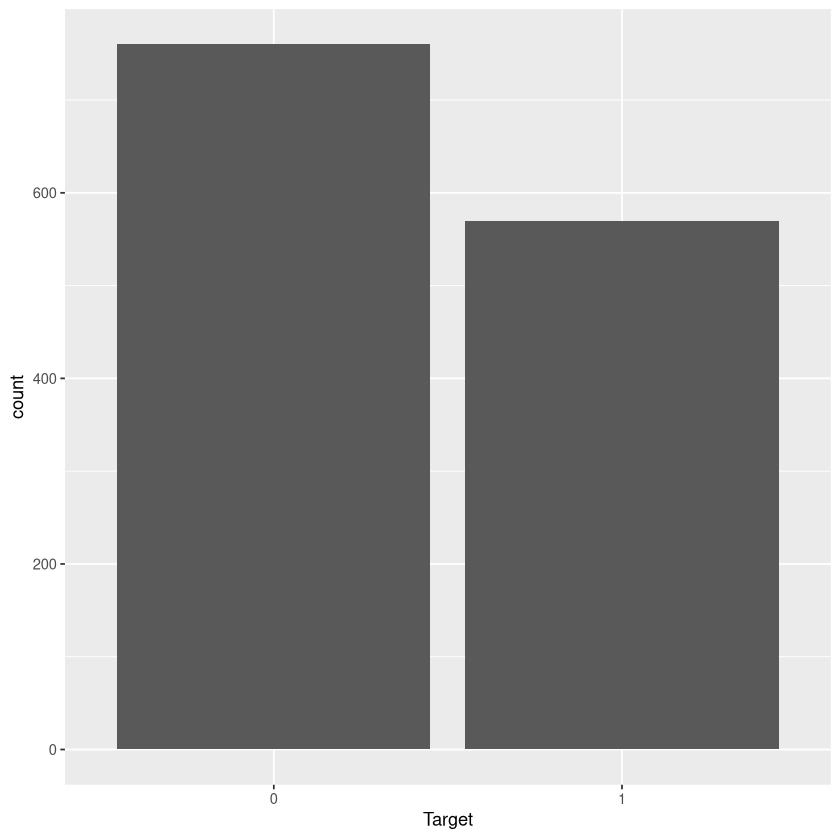

,Education,JobInvolvement,JobLevel,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Target,Gender_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Age_1,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1,DistanceFromHome_1,AgvSatisfy
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
79,4,3,4,0,3,3,0,1,2,0,1,2,1,3,6,3,2.3535221,1.58126866,3.5008244,4.8294004,1.5676731,-0.3681889,1.06289868,0.1206392,4
431,2,3,2,3,3,4,0,2,3,0,0,2,3,3,4,3,-0.3139855,-0.06754281,-0.1548527,-0.3376177,-0.8947174,0.5732122,-0.32682777,-0.1291275,2
647,1,2,1,0,3,1,0,2,1,0,1,2,3,2,5,2,-0.9808624,-0.69485904,-0.6770923,-0.3376177,-0.3475195,-0.6819892,-0.04888248,-0.8784277,2
736,2,4,5,1,3,4,2,4,2,0,1,2,3,2,2,1,0.7974760,2.71559976,1.9341057,2.8917687,1.2940742,3.7112159,2.45262513,-0.6286610,2
23,4,3,2,0,3,4,1,2,3,0,1,2,1,4,6,2,0.5751837,0.07814131,-0.1548527,0.3082596,0.7468763,0.5732122,-0.60477306,-0.1291275,2
721,3,3,2,1,3,2,2,2,3,0,1,2,3,2,4,1,-0.8697163,0.03505465,-0.6770923,-0.1761483,-1.1683163,-0.3681889,-1.16066363,-0.2540109,4


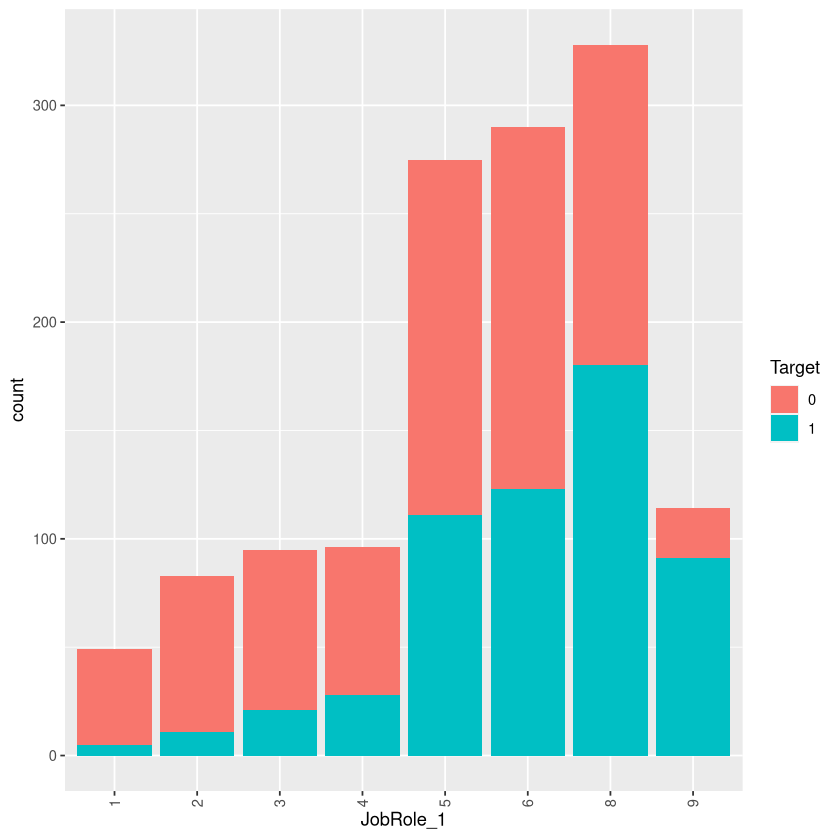

In [23]:
fold <- 3
index <- 3
df.rsmpl <- SMOTE(Target ~ ., df.procd, perc.over = 200, perc.under=200)
# df.rsmpl <- df.procd
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df.rsmpl, fold, index, fold_indices)
ggplot(df.rsmpl, aes(x = Target)) + geom_bar()
ggplot(df.rsmpl, aes(x = JobRole_1, fill = Target)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
head(splitted_frames$training)

### 模型訓練

#### DecisionTree 分類器函式

In [24]:
train_dt <- function(df, depth=5) {
  model <- rpart(
    Target ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_class <- predict(model, df, type = "class")
  pred_prob <- predict(model, df, type="prob")
  return (list(class=pred_class,
              prob=pred_prob))
}

#### RandomForest 分類器函式

In [25]:
train_rf <- function(df, mtry=9, ntree=100, maxnodes = 100) {
   model <- randomForest(
     Target ~ .,
     data = df,
     mtry = mtry,
     importance=TRUE,
     proximity=TRUE,
     ntree=ntree,
     maxnodes=maxnodes)
   return (model)
 }
 predict_rf <- function(model, df) {
   pred_class <- predict(model, df, type = "class")
   pred_prob <- predict(model, df, type = "prob")
   
   return (list(class=pred_class,
               prob=pred_prob))
 }

#### Logistic Regression 分類器函式

In [26]:
train_lg <- function(df) {
  model <- glm(
    Target ~ .,
    data = df,
    family = "binomial")
  return (model)
}

predict_lg <- function(model, df, attrition_rate=0.5) {
  pred_prob <- predict(model, df, type="response")
  pred_class <- ifelse(pred_prob > attrition_rate, 1, 0)  
  return (list(class=pred_class,
              prob=pred_prob))
}

### SVM 分類器函式

In [27]:
train_sv <- function(df, kernel='linear') {
  model_prob <- svm(
    Target ~ .,
    data = df,
    kernel = kernel,
    probability = TRUE)
  
  model_class <- svm(
    Target ~ .,
    data = df,
    kernel = kernel,
    probability = FALSE)
  return (list(class=model_class,
               prob=model_prob))
}
predict_sv <- function(model, df) {
  pred_class <- predict(model$class, df, probability = FALSE)
  pred_prob <- predict(model$prob, df, probability = TRUE)
  return (list(class=pred_class,
              prob=pred_prob))
}

### AdaBoost 分類器函式

In [40]:
train_ad <- function(df, n=10) {
  model <- adaboost(Target ~ ., df, n)
  return (model)
}
predict_ad <- function(model, df) {
  pred <- predict(model, df, prob=TRUE)
  # pred_prob <- predict(model, df, type = "prob")
  return (pred)
}

#### 模型訓練

In [52]:
# trainer <- (function(df) train_dt(df, 8))
# predictor <- (function(model, df) predict_dt(model, df))
# trainer <- (function(df) train_lg(df))
# predictor <- (function(model, df) predict_lg(model, df))
trainer <- (function(df) train_rf(df, 4, 100))
predictor <- (function(model, df) predict_rf(model, df))
# trainer <- (function(df) train_sv(df, kernel='sigmoid'))
# predictor <- (function(model, df) predict_sv(model, df))
# trainer <- (function(df) train_ad(df, 10))
# predictor <- (function(model, df) predict_ad(model, df))

model <- trainer(splitted_frames$training)

### 模型評估

#### 預備模型評估的函式

In [53]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Target,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}
cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}
get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}
cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}
cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}
cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}
cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}
cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}
evaluate_model <- function(df, pred){
  pred_class <- pred$class
  pred_prob <- pred$prob
  predict_cm <- build_cm(df, pred_class)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  
  # svm
  # attr(pred_prob, 'probabilities')
  # roc_pred <- prediction(attr(pred_prob, 'probabilities')[, 1], df$Target)
  
  # normal
  roc_pred <- prediction(pred_prob[, 2], df$Target)
  
  roc_perf <- performance(roc_pred, measure = 'auc')
  r2 <- cor(as.numeric(df$Target), as.numeric(pred_class)) ^ 2
  
  return(list(cm=predict_cm,
              result=predict_result,
              accuracy=accu,
              recall=recl,
              precision=preci,
              sensitivity=sens,
              specificity=spec,
              F1=f1,
              AUC=roc_perf@y.values[[1]],
              R2=r2))
}

#### 評估模型預測結果

##### 訓練資料集

In [54]:
print('training:')
pred_train <- predictor(model, splitted_frames$training)
# print(pred_train)

result_train <- evaluate_model(splitted_frames$training, pred_train)
print(result_train)

[1] "training:"
$cm
     pred
truth   0   1
    0 507   0
    1   8 372

$result
 TP  FP  TN  FN 
372   0 507   8 

$accuracy
[1] 0.99

$recall
[1] 0.98

$precision
[1] 1

$sensitivity
[1] 0.98

$specificity
[1] 1

$F1
[1] 0.99

$AUC
[1] 0.9999325

$R2
[1] 0.9637404



##### 驗證資料集

In [55]:
print('validation:')
pred_valid <- predictor(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
print(result_valid)

[1] "validation:"
$cm
     pred
truth   0   1
    0 243  10
    1  35 155

$result
 TP  FP  TN  FN 
155  10 243  35 

$accuracy
[1] 0.9

$recall
[1] 0.82

$precision
[1] 0.94

$sensitivity
[1] 0.82

$specificity
[1] 0.96

$F1
[1] 0.88

$AUC
[1] 0.9597982

$R2
[1] 0.6314864



### 執行最後測試的資料

In [56]:
print('testing:')
model.rsmpl <- trainer(df.rsmpl)
df.test2 <- wrangler(df.test)
pred_test <- predictor(model.rsmpl, df.test2)
# pred_test <- predictor(model, df.test2)
result_test <- evaluate_model(df.test2, pred_test)
print(result_test)

[1] "testing:"
$cm
     pred
truth   0   1
    0 220  26
    1  26  21

$result
 TP  FP  TN  FN 
 21  26 220  26 

$accuracy
[1] 0.82

$recall
[1] 0.45

$precision
[1] 0.45

$sensitivity
[1] 0.45

$specificity
[1] 0.89

$F1
[1] 0.45

$AUC
[1] 0.7711036

$R2
[1] 0.1163611

